In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import ipywidgets as widgets
import time
from scipy import linalg
from scipy import optimize
import sympy as sm
import pandas as pd

from plotter import PlotterWindow

sm.init_printing(use_unicode=True)

In [2]:
mu_t = sm.symbols("mu_t")
mu_t1 = sm.symbols("mu_t-1")
b_t = sm.symbols("b_t")
a_t = sm.symbols("a_t")
p_t = sm.symbols("P_t")
v = sm.symbols("v")
v_h = sm.symbols("v^H")
v_l = sm.symbols("v^L")
d_t = sm.symbols("d_t")
sd_t = sm.symbols("s(d_t)")
s_a = sm.symbols("s_t^a")
s_b = sm.symbols("s_t^b")
theta_t = sm.symbols("theta_t")
theta_t1 = sm.symbols("theta_t-1")
pi = sm.symbols("pi")
beta_b = sm.symbols("beta_B")
beta_s = sm.symbols("beta_S")
spib = sm.symbols("Pi_buy")
spis = sm.symbols("Pi_sell")


In [3]:
minimering = abs(v-p_t)



spib = theta_t1*pi*(a_t-v_h)+beta_b*(1-pi)*(a_t-mu_t1)
spis = (1-theta_t1)*pi*(v_l-b_t)+beta_s*(1-pi)*(mu_t1-b_t)

a_t = mu_t1 + s_a
b_t = mu_t1 + s_b

s_a = (pi*theta_t1*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_b)*(v_h-v_l)
s_b = (pi*(1-theta_t1)*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_s)*(v_h-v_l)



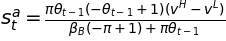

In [4]:
sm.Eq(sm.symbols("s_t^a"), s_a)

In [5]:
p_t

In [6]:
p = sm.symbols("p(BUY|v_h)\space")
p

p(BUY|v_h)\space

![Flowchart](flowchart.png)

In [7]:
def simulation(distribution=(0,1), decision="v_h", ratio=0.2, uninformed=0.5, startvalue=0.5, iterations = 500, seed=5000, epsilon=10**-5, shockperiod = None, shock={}):
    #define constants
    v_l, v_h = distribution
    pi = ratio
    beta_b = uninformed
    beta_s = 1-beta_b
    shock = shock
    
    #determine realized value of v
    v = decision
    
    #allocate space
    values=[]
    ratiovalues = []
    iteration = []
    thetavalues = np.empty(iterations)
    muvalues = np.empty(iterations)
    askvalues = np.empty(iterations)
    bidvalues = np.empty(iterations)
    gapvalues = np.empty(iterations)
    pivalues = np.empty(iterations)
    decisionvalues = np.empty(iterations)
    
    #simulation settings
    thetavalues[0]=startvalue
    theta_t1 = startvalue
    N = iterations
    np.random.seed(seed)
    
    break_index = 0
    for i in range(N):
        
        if i==shockperiod:
            if shock != {}:
                if "Public" not in shock:
                    if shock["Private"]==1:
                        v="v_h"
                    if shock["Private"]==0:
                        v="v_l"

                elif "Private" not in shock:
                    v_l, v_h = shock["Public"] 
                    v = decision
                
                else:
                    v_l, v_h = shock["Public"]
                    if shock["Private"]==1:
                        v="v_h"
                    if shock["Private"]==0:
                        v="v_l"
                    
        if v=="v_h":
            v=v_h
        elif v=="v_l":
            v=v_l
            
        
        mu_t1 = theta_t1*v_h+(1-theta_t1)*v_l
        muvalues[i] = mu_t1
        
        #calculate markup/discount
        s_a = (pi*theta_t1*(1-theta_t1))/(pi*theta_t1+(1-pi)*beta_b)*(v_h-v_l)
        s_b = (pi*theta_t1*(1-theta_t1))/(pi*(1-theta_t1)+(1-pi)*beta_s)*(v_h-v_l)
        
        #calculate ask/bid price
        askvalues[i] = a_t = mu_t1 + s_a
        bidvalues[i] = b_t = mu_t1 - s_b 
        
        #calculate gap
        gapvalues[i] = gap_t = a_t - b_t
        
        #realize pi
        trader = np.random.binomial(1,pi)
        pivalues[i] = trader
        #if trader is informed
        if trader == 1:
            if v == v_h:
                if v_h>a_t:
                    d_t=1
            elif v == v_l:
                if v_l<b_t:
                    d_t=-1
            else:
                d_t=0
                    
        #if trader is uninformed
        if trader == 0:
            buysell = np.random.binomial(1,beta_b)
            if buysell == 1:
                d_t = 1
            else:
                d_t = -1
        
        decisionvalues[i] = d_t
        
        #update theta
        if d_t == 1:
            theta_t = ((1+pi)*beta_b)/(pi*theta_t1+(1-pi)*beta_b)*theta_t1
            theta_t1 = theta_t
        elif d_t == -1:
            theta_t = ((1-pi)*beta_b)/(pi*(1-theta_t1)+(1-pi)*beta_b)*theta_t1
            theta_t1 = theta_t
        
        if i<iterations-1:
            thetavalues[i+1] = theta_t
        ratiovalues.append(str(ratio))
        iteration.append(int(i))
        
        #off by one error
        break_index=i+1
        if gap_t<epsilon or i == N-1:
            values.extend(["Theta: "+str(theta_t), "Bid: "+str(b_t), "Ask: "+str(a_t), "Mu: "+str(mu_t1)])
            break
            
    
    dataframe = pd.DataFrame()
    dataframe["Iteration"]=iteration
    dataframe["ratio"] = ratiovalues
    dataframe["theta"] = thetavalues[0:break_index]
    dataframe["mu"] = muvalues[0:break_index]
    dataframe["ask"] = askvalues[0:break_index]
    dataframe["bid"] = bidvalues[0:break_index]
    dataframe["spread"] = gapvalues[0:break_index]
    dataframe["trader"] = pivalues[0:break_index]
    dataframe["order"] = decisionvalues[0:break_index]
    
    return dataframe, values

In [8]:
thetarun1 = simulation(ratio=0.15, iterations=201,seed=4795)
thetarun2 = simulation(ratio=0.15, iterations=201,seed=6279)
thetarun3 = simulation(ratio=0.15, iterations=201,seed=6130)
thetarun4 = simulation(ratio=0.15, iterations=201,seed=9352)
thetarun5 = simulation(ratio=0.15, iterations=201,seed=5059)

thetadata1, thetavalues1 = thetarun1
thetadata2, thetavalues2 = thetarun2
thetadata3, thetavalues3 = thetarun3
thetadata4, thetavalues4 = thetarun4
thetadata5, thetavalues5 = thetarun5

Text(0.5, 1.0, 'Theta')

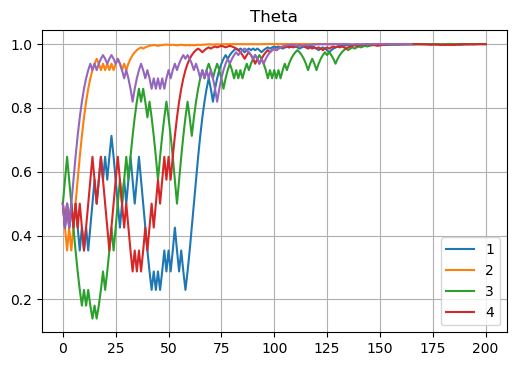

In [9]:
fig = plt.figure(dpi=100)
ax2 = fig.add_subplot(1,1,1)
ax2.plot(thetadata1["theta"], label="1")
ax2.plot(thetadata2["theta"], label="2")
ax2.plot(thetadata3["theta"], label="3")
ax2.plot(thetadata4["theta"], label="4")
ax2.plot(thetadata5["theta"], label="")
ax2.grid(True)
ax2.legend()
ax2.set_title("Theta")

In [10]:
pirun1 = simulation(ratio=0.10, iterations=1001, seed=404)
pirun2 = simulation(ratio=0.15, iterations=1001, seed=404)
pirun3 = simulation(ratio=0.25, iterations=1001, seed=404)
pirun4 = simulation(ratio=0.5, iterations=201, seed=404)
pirun5 = simulation(ratio=0.9, iterations=201, seed=404)

pirundata1, pirunvalues1 = pirun1
pirundata2, pirunvalues2 = pirun2
pirundata3, pirunvalues3 = pirun3 
pirundata4, pirunvalues4 = pirun4
pirundata5, pirunvalues5 = pirun5

pirunmerged = pd.concat([pirundata1, pirundata2, pirundata3, pirundata4, pirundata5])

In [11]:
pirungraphwindow = PlotterWindow(data = pirunmerged, slicename = "ratio", xvariable = "Iteration", yvariablelist = ["mu","ask","bid"], graphtype ="piplot")
pirungraphwindow.start()

C:\Users\Corfixen\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [12]:
pirungraphwindow2 = PlotterWindow(data = pirunmerged, slicename = "ratio", graphtype = "candlestick")
pirungraphwindow2.start()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [13]:
shockrun1 = simulation(ratio=0.151, iterations=1001, seed=404, shockperiod = 90, shock={"Private":0})
shockrun2 = simulation(ratio=0.152, iterations=1001, seed=404, shockperiod = 90, shock={"Public":(0.3, 0.8)})
shockrun3 = simulation(ratio=0.153, iterations=1001, seed=404, shockperiod = 90, shock={"Private":0, "Public":(0.3,0.8)})

shockdata1, shockvalues1 = shockrun1
shockdata2, shockvalues2 = shockrun2
shockdata3, shockvalues3 = shockrun3

shockmerged = pd.concat([shockdata1,shockdata2,shockdata3])

In [14]:
shockgraphwindow = PlotterWindow(data = shockmerged, slicename = "ratio", xvariable = "Iteration", yvariablelist = ["mu","ask","bid"], graphtype="piplot")
shockgraphwindow.start()